In [23]:
%pip install -r req.txt


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /home/wtl04/coding/snapsend/computer_vision/venv310/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV

# models
from sklearn.linear_model import LogisticRegression # linear
import xgboost as xgb # ensemble
from sklearn.ensemble import RandomForestClassifier, VotingClassifier # ensemble
from sklearn.svm import SVC # support vector machine

# evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


# Data Preprocessing

In [27]:
dataframe = pd.read_csv("./datasets/Orientation-Based Analysis of 3D Printing Parameters and Quality Control/Orientation-Based Analysis of 3D Printing Parameters and Quality Control.csv")

# no truth labels for print failure or not so creating pseudo print failure label
dataframe['likely_failure'] = (
    (dataframe['Wair'] > 0) |
    (dataframe['Wair_partial'] > 0) |
    (dataframe['Farea'] < 10) |
    (dataframe['offset'] == 0) |
    (dataframe['Fwall'] == 0) |
    (dataframe['needsupport'] == 1)
).astype(int)  # 1 = likely to fail, 0 = normal

dataframe = dataframe.drop(columns=['model']) # remove model ID column

# standardize dataset
scaler = StandardScaler()
scaler.fit_transform(dataframe)

array([[ 1.17337599,  0.24151722,  1.72981954, ..., -0.35788909,
        -1.20407608,  0.6165148 ],
       [ 2.50294844,  0.24151722,  0.7040893 , ..., -0.35788909,
         0.83051231,  0.6165148 ],
       [ 2.50294844,  0.24151722,  0.7040893 , ..., -0.35788909,
         0.83051231,  0.6165148 ],
       ...,
       [-0.78113287, -0.90904202, -0.89158967, ..., -0.35746319,
         0.83051231,  0.6165148 ],
       [-0.89497564, -0.90904202, -0.80376296, ..., -0.35788909,
         0.83051231,  0.6165148 ],
       [-0.89497564, -0.90904202, -0.80376296, ..., -0.35788909,
         0.83051231,  0.6165148 ]])

In [28]:
dataframe['likely_failure'].value_counts()

likely_failure
1    442
0    168
Name: count, dtype: int64

In [29]:
X = dataframe.drop(columns=['likely_failure'])
y = dataframe['likely_failure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training

### Logistic Regression

In [43]:
lr = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


### Random Forest

In [44]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### XGBoost

In [45]:
xgboost = xgb.XGBClassifier(objective='binary:logistic',
                              n_estimators=100,
                              learning_rate=0.1,
                              max_depth=5,
                              random_state=42)
xgboost.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### Support Vector Machine (SVM)

In [53]:
# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
svm = SVC(kernel='rbf',probability=True, random_state=42)
svm.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


### Voting Classifier

In [54]:
vc = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('rf', rf),
        ('xgb', xgboost),
        ('svm', svm)
    ],
    voting='soft'  # 'soft' = use predicted probabilities, 'hard' = majority vote
)
vc.fit(X_train, y_train)

,estimators,"[('lr', ...), ('rf', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True


### Model Evaluation

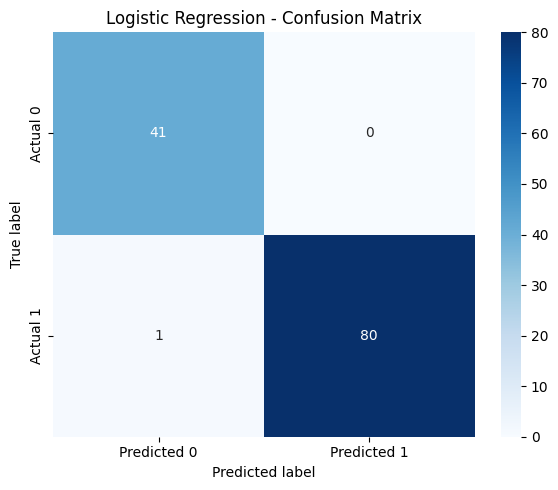

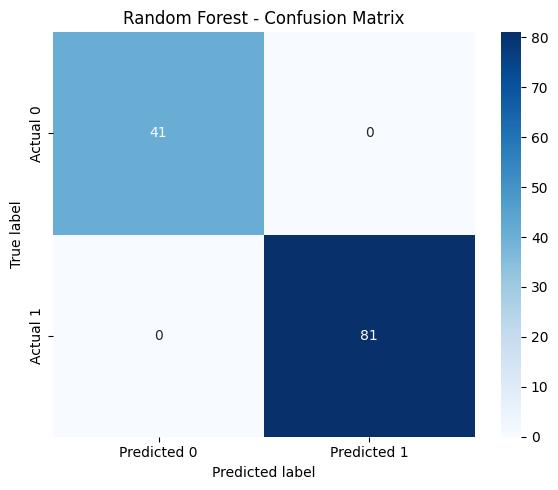

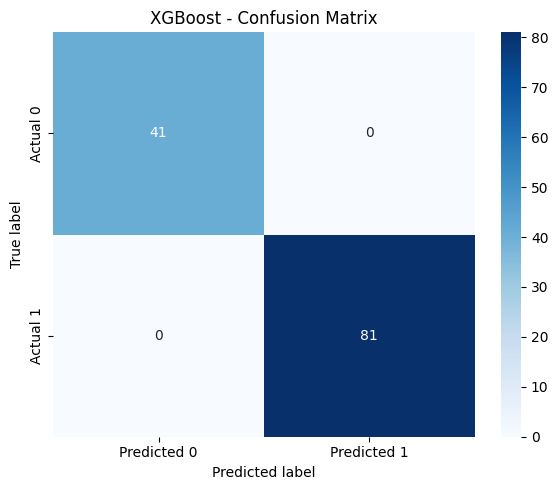

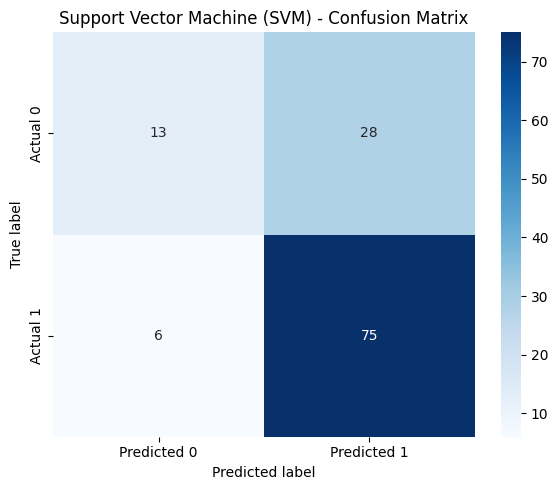

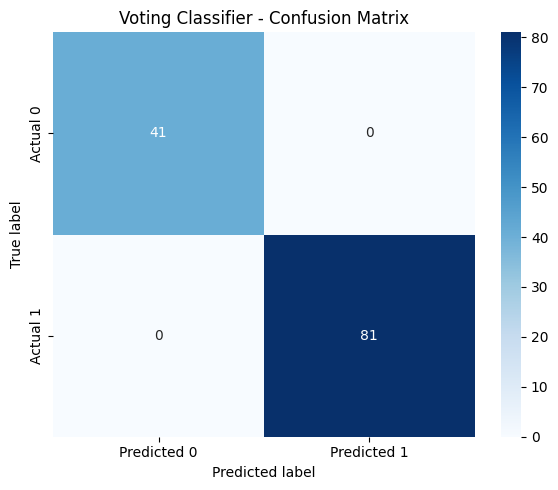

In [59]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

# Predict using each model
lr_pred = lr.predict(X_test)
rf_pred = rf.predict(X_test)
xgb_pred = xgboost.predict(X_test)
svm_pred = svm.predict(X_test)
voting_pred = vc.predict(X_test)

# Plot confusion matrices
plot_confusion_matrix(y_test, lr_pred, "Logistic Regression - Confusion Matrix")
plot_confusion_matrix(y_test, rf_pred, "Random Forest - Confusion Matrix")
plot_confusion_matrix(y_test, xgb_pred, "XGBoost - Confusion Matrix")
plot_confusion_matrix(y_test, svm_pred, "Support Vector Machine (SVM) - Confusion Matrix")
plot_confusion_matrix(y_test, voting_pred, "Voting Classifier - Confusion Matrix")
